In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import maboss
#import ginsim

## Toy model

The following introduces a toy model accounting for differentation process in two cell types T1 and T2: 
    an input node I activate a node A drive the cell in type T1; 
    in parralel, the node A activate a ligand L, that will trigger a receptor R that drives the cell in type T2. 
    To avoid cross cell types, T2 is only activated without A and T1 is only activated when cell in not in type T2.

In [2]:
# Set up the required files
bnd_file ="ToyModelUP.bnd"
cfg_file = "ToyModelUP.cfg"
upp_file = "ToyModelUP.upp"

The update of node R depends on an external parameter `$innerOn`.

In [3]:
model_maboss = maboss.load(bnd_file,cfg_file)
model_maboss.print_bnd()

Node I {


	rate_up = 0.0;
	rate_down = 0.0;
}
Node A {


	rate_up = I ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node L {


	rate_up = A ? 1.0 : 0.0;
	rate_down = 0.0;
}

Node R {


	rate_up = $innerOn ? L : $outerL;
	rate_down = 0.0;
}

Node T1 {


	rate_up = (A & (!T2)) ? 1.0 :0.0;
	rate_down = 0.0;
}

Node T2 {


	rate_up = (R & (!A)) ? 1.0 : 0.0;
	rate_down = 0.0;
}


Activation of R depends on L:
- If `$innerOn` is set at 1, R is activated by the state of L inside the cell.
- If `$innerOn` is set at 0, R is activted by the population state of L, through update of `$outerL` described in the `upp` file.

In [4]:
ufile = open(upp_file, 'r') 
print(ufile.read())
ufile.close()

$outerL u= 5*p[(L) = (1)];
steps = 15;
MaBoSS = MaBoSS;


Let's consider the two cases, and run them with UPMaBoSS (the case "innerOn" could have been simulted simply by MaBoSS, as there is no use of the updated parameter `$outerL`).

In [5]:
model_maboss = maboss.load(bnd_file,cfg_file)
model_maboss.update_parameters(max_time=1)

model_maboss_innerOn = maboss.copy_and_update_parameters(model_maboss,{"$innerOn":1})
model_upmaboss_innerOn = maboss.UpdatePopulation(model_maboss_innerOn, upp_file)

model_maboss_innerOff = maboss.copy_and_update_parameters(model_maboss,{"$innerOn":0})
model_upmaboss_innerOff = maboss.UpdatePopulation(model_maboss_innerOff, upp_file)

CPU times: user 83.2 ms, sys: 113 ms, total: 196 ms
Wall time: 14.4 s


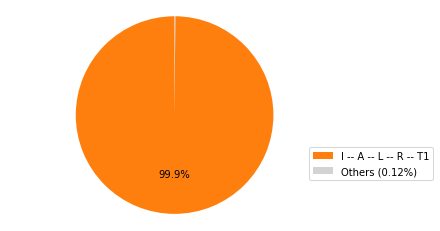

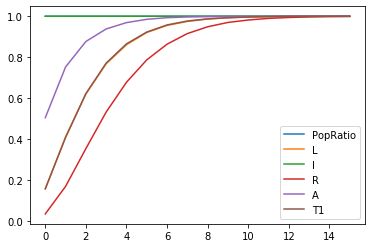

In [6]:
%time ur = model_upmaboss_innerOn.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("On_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("On_pop_traj.pdf")

CPU times: user 84 ms, sys: 130 ms, total: 215 ms
Wall time: 14.3 s


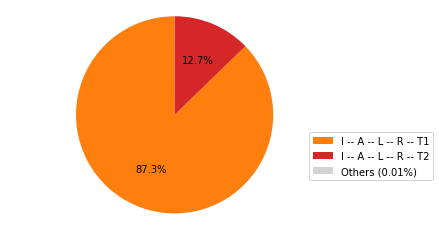

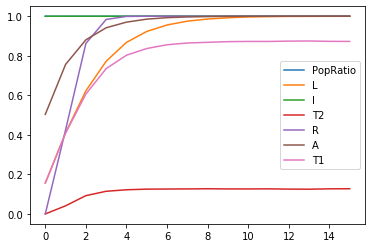

In [7]:
%time ur = model_upmaboss_innerOff.run()

ur.results[-1].plot_piechart()
ur.results[-1]._piefig.savefig("Off_pop_pie.pdf")

traj = ur.get_nodes_stepwise_probability_distribution()
p = traj.plot()
p.get_figure().savefig("Off_pop_traj.pdf")

The node T2 can only be activated if the node R is updated acccording to the population state of L.